# Lesson 6. Gradient boosting

In [1]:
from sklearn.tree import DecisionTreeRegressor

import plotly.graph_objects as go

from sklearn import model_selection
import numpy as np
import pandas as pd

Используем один из "игрушечных" датасетов из той же библиотеки.

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = [mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta))]
    test_errors = [mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta))]
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            trees.append(tree)
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            trees.append(tree)
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        # trees.append(tree) 
        
    return trees, train_errors, test_errors

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

## Построим графики зависимости ошибки от количества деревьев в ансамбле

Была модифицирована функция gb_fit: ранее обученное дерево добавлялось в список trees уже после расчёта mse на train и test, т.о. терялась ошибка при максимальном кол-ве деревьев. Исправления: 
- при объявлении массива ошибок в него сразу помещается mse для предсказаний начального алгоритма (пустое дерево предсказывает для всех объектов 0) train_errors = [mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta))]
- trees.append(tree) выполняется сразу после обучения дерева, а не в конце цикла, поэтому теперь на каждом шаге мы измеряем mse для всех деревьев, в том числе только что обученного

[Text(0, 0.5, 'mse'), Text(0.5, 0, 'n_trees')]

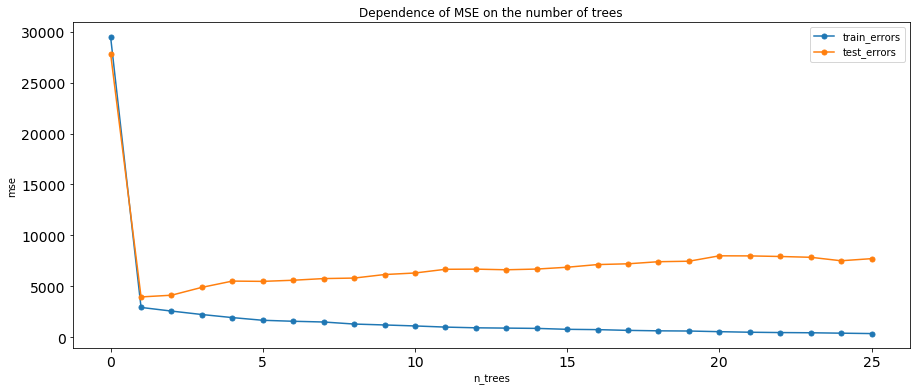

In [10]:
n_trees = 25
coefs = [1] * n_trees
max_depth = 3
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

res = pd.DataFrame.from_dict({'train_errors': train_errors, 'test_errors': test_errors})
ax = res.plot(title='Dependence of MSE on the number of trees', figsize=(15,6), fontsize=14, style='.-', ms=10)
ax.set(xlabel="n_trees", ylabel="mse")

### При увеличении кол-ва деревьев (итераций) ошибка должна уменьшаться, однако в нашем случае наблюдается переобучение уже со второго дерева: ошибка на тестовой выборке растёт, а на обучающей уменьшается. Можно сделать вывод, что модель переобучилась под обучающую выборку и ухудшила свою предсказательную способность. Попробуем уменьшить к-т eta

[Text(0, 0.5, 'mse'), Text(0.5, 0, 'n_trees')]

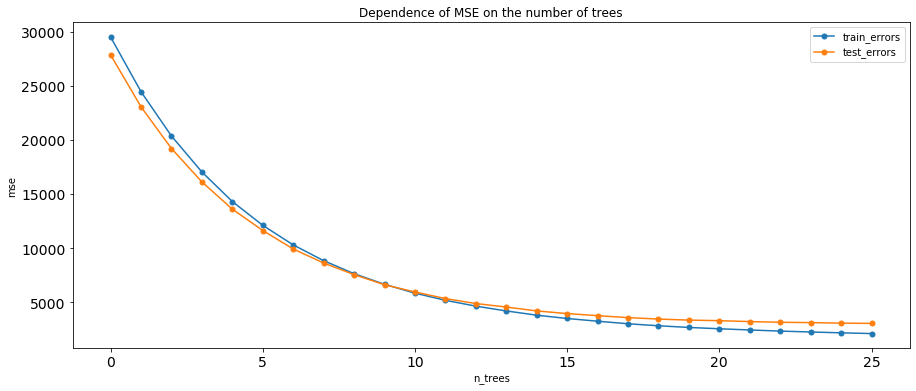

In [11]:
n_trees = 25
coefs = [1] * n_trees
max_depth = 3
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

res = pd.DataFrame.from_dict({'train_errors': train_errors, 'test_errors': test_errors})
ax = res.plot(title='Dependence of MSE on the number of trees', figsize=(15,6), fontsize=14, style='.-', ms=10)
ax.set(xlabel="n_trees", ylabel="mse")

### Как видно, при уменьшении к-та eta получилось избежать переобучения и добиться уменьшения mse на тестовой выборке при увеличении кол-ва деревьев (итераций)

[Text(0, 0.5, 'mse'), Text(0.5, 0, 'n_trees')]

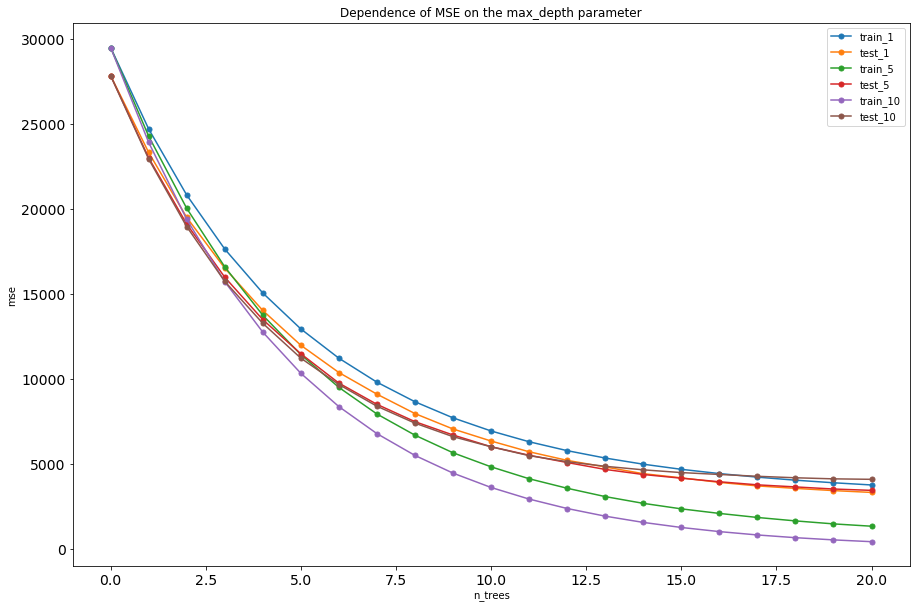

In [13]:
n_trees = 20
coefs = [1] * n_trees
eta = 0.1

res_dict = {}
for max_depth in [1,5,10]:
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    res_dict[f'train_{max_depth}'] = train_errors
    res_dict[f'test_{max_depth}'] = test_errors

res = pd.DataFrame.from_dict(res_dict)
ax = res.plot(title='Dependence of MSE on the max_depth parameter', figsize=(15,10), fontsize=14, style='.-', ms=10)
ax.set(xlabel="n_trees", ylabel="mse")

### Как видим, если выбрать слишком глубокое дерево для нашего количества признаков, модель начинает переобучаться: при каждой новой итерации увеличивается разрыв между метрикой на train и test - train mse снижвается в то время, как test mse увеличивается